In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
tfpl = tfp.layers

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [55]:
def plot_distribution(samples):
    ax = plt.axes()
    ax.set_facecolor("black")
    plt.scatter(samples[:, 0], samples[:, 1], marker='.', alpha=0.2)
    plt.xlim([-1,1])
    plt.ylim([-1,1])
    #plt.axis('equal')
    plt.show()

def plot_contour2(td):
    zpoints = np.linspace(-1, 1, 150)
    z1, z2, = np.meshgrid(zpoints, zpoints)
    zgrid = np.concatenate((z1.reshape(-1, 1), z2.reshape(-1,1)), axis=1)
    p = np.exp(td.log_prob(zgrid))
    fig = plt.figure()
    plt.imshow(p.reshape(z1.shape), aspect='equal', extent=[-1,1, -1, 1])
    plt.show()
    
def plot_contour(dist):
    xx = np.linspace(-0.5, 0.5, 100)
    yy = np.linspace(-0.5, 0.5, 100)
    X, Y = np.meshgrid(xx, yy)

    fig,ax=plt.subplots(1,1)
    Z = dist.prob(np.dstack((X, Y)))
    cp = ax.contourf(X, Y, Z)
    fig.colorbar(cp) # Add a colorbar to a plot
    ax.set_title('Filled Contours Plot')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    plt.show()

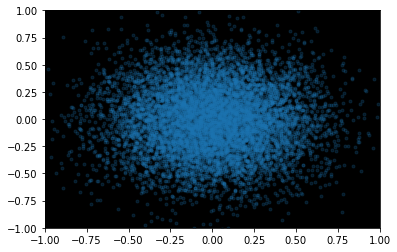

In [41]:
sigma = 0.3
z = tfd.MultivariateNormalDiag(loc=tf.zeros(2), scale_diag=sigma*tf.ones(2))
samples = z.sample(10000)
plot_distribution(samples)
#plot_contour(z)

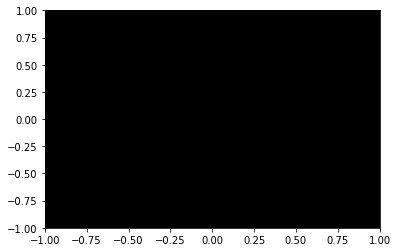

In [42]:
# f1, f2
# 𝑓1(𝑧)=(𝑧1,𝑧2−2)
# 𝑓2(𝑧)=(𝑧1,𝑧2/2)
x = tfd.TransformedDistribution(z, 
                                bijector=tfb.AffineLinearOperator(
                                    scale=tf.linalg.LinearOperatorDiag([1,1/2]), 
                                    shift=[0.,-2]
                                )
                               )
samples = x.sample(10000)
plot_distribution(samples)
#plot_contour(x)

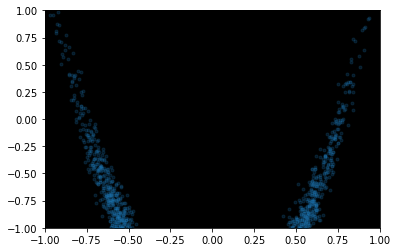

In [43]:
# f3(𝑧)=(𝑧1,𝑧2+𝑎𝑧1^2) 
class Polynomial(tfb.Bijector):

    def __init__(self, a):
        self.a = tf.cast(a, dtype=tf.float32)
        super(Polynomial, self).__init__(forward_min_event_ndims=1, is_constant_jacobian=True)
        
    def _forward(self, x):
        x = tf.cast(x, dtype=tf.float32)
        return tf.concat([x[..., :1], 
                          x[..., 1:] + self.a * tf.square(x[..., :1])], axis=-1)
    
    def _inverse(self, y):
        y = tf.cast(y, dtype=tf.float32)
        return tf.concat([y[..., :1], 
                          y[..., 1:] - self.a * tf.square(y[..., :1])], axis=-1)
        
    def _forward_log_det_jacobian(self, x):
        return tf.constant(0., dtype=x.dtype)

a = tf.random.normal((), 3, 1) #tfd.Normal(loc=3, scale=1)
f3 = Polynomial(a)
x = f3(x)
samples = x.sample(10000)
plot_distribution(samples)
#plot_contour(x)

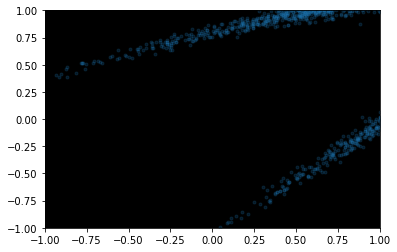

In [44]:
# f4(𝑧)=Rz
class Rotation(tfb.Bijector):

    def __init__(self, theta):
        self.theta = theta
        self.R = tf.convert_to_tensor([[tf.math.cos(theta), -tf.math.sin(theta)], 
                                       [tf.math.sin(theta), tf.math.cos(theta)]], dtype=tf.float32)
        super(Rotation, self).__init__(forward_min_event_ndims=1, is_constant_jacobian=True)
        
    def _forward(self, x):
        x = tf.cast(x, dtype=tf.float32)
        return tf.linalg.matvec(self.R, x)
    
    def _inverse(self, y):
        y = tf.cast(y, dtype=tf.float32)
        return tf.linalg.matvec(tf.transpose(self.R), x)
    
    def _forward_log_det_jacobian(self, x):
        return tf.constant(0., x.dtype)

theta = tf.random.uniform((), 0, 2*np.pi) #tfd.Normal(loc=3, scale=1)
f4 = Rotation(theta)
x = f4(x)
samples = x.sample(10000)
plot_distribution(samples)
#plot_contour(x)

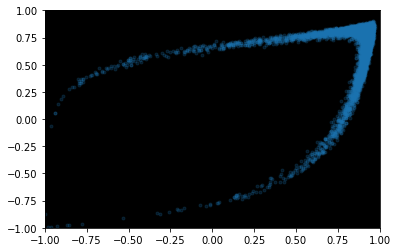

In [45]:
# f5(𝑧)=tanh(z)
f5 = tfb.Tanh()
x = f5(x)
samples = x.sample(10000)
plot_distribution(samples)
#plot_contour(x)

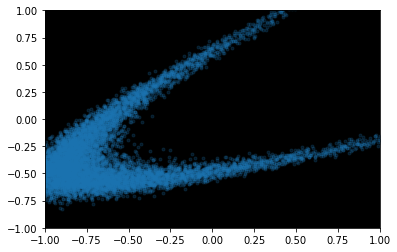

In [63]:
sigma = 0.3
base_distribution = tfd.MultivariateNormalDiag(loc=tf.zeros(2), scale_diag=sigma*tf.ones(2))
a = tfd.Normal(loc=3, scale=1).sample(1)[0].numpy()
theta = tfd.Uniform(low = 0, high = 2*np.pi).sample(1)[0].numpy()
bijectors = [
                #tfb.AffineLinearOperator(
                #                        shift=[0.,-2],
                #                        scale=tf.linalg.LinearOperatorDiag([1,1/2])
                #),
                tfb.Shift([0.,-2]),
                tfb.Scale([1,1/2]),
                Polynomial(a),
                Rotation(theta),
                tfb.Tanh()
           ]
flow_bijector = tfb.Chain(list(reversed(bijectors[:-1])))
transformed_distribution = tfd.TransformedDistribution(distribution=base_distribution,
                                                    bijector=flow_bijector)
samples = transformed_distribution.sample(10000)
plot_distribution(samples)
#plot_contour(transformed_distribution)

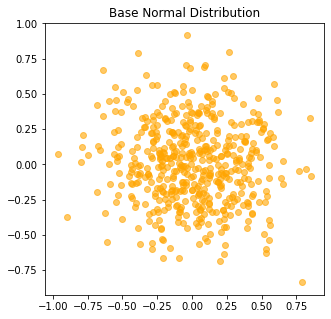

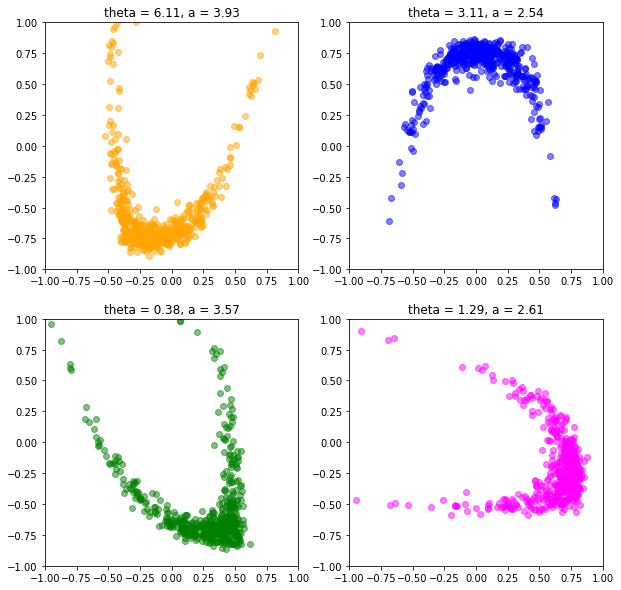

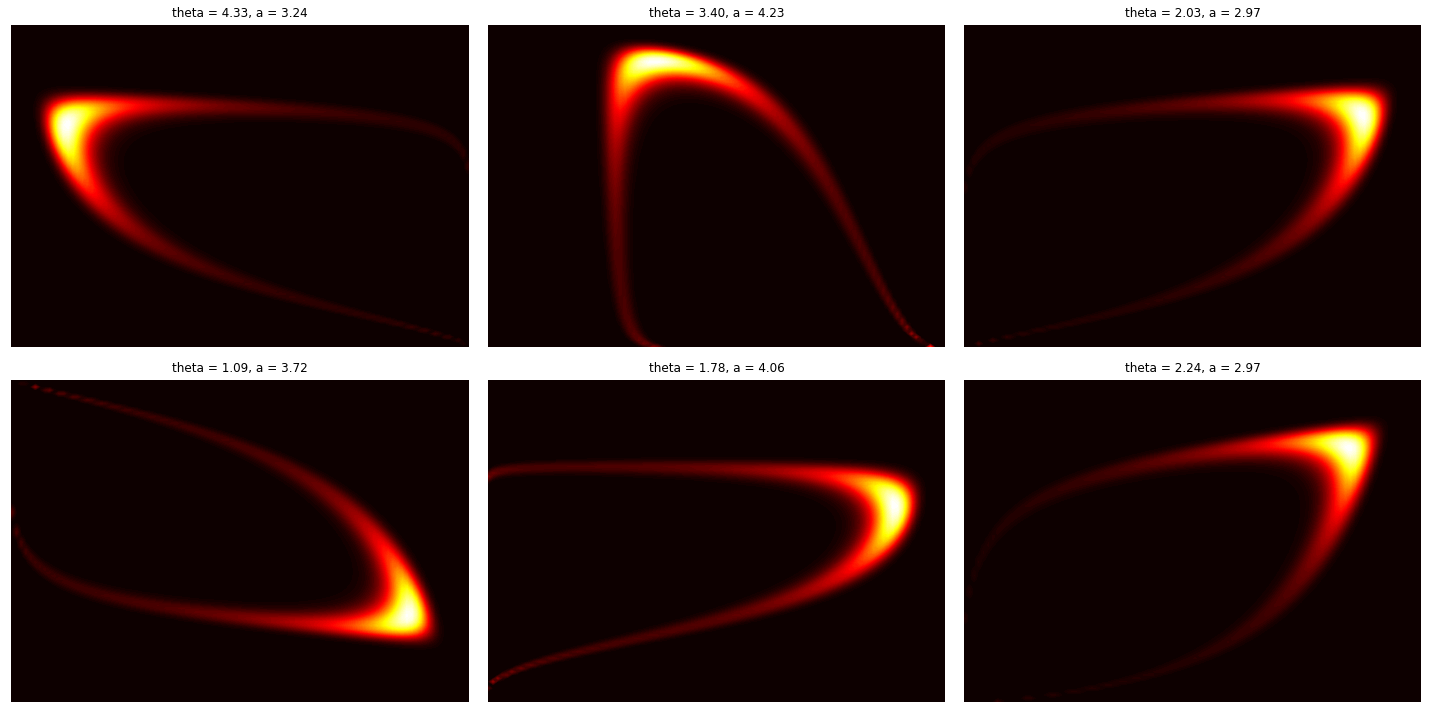

In [64]:
# Base Distribution

theta_dist = tfd.Uniform(low = 0, high = 2*np.pi)
a_dist = tfd.Normal(loc = 3, scale = 1)

mu, sigma = 0, 0.3
base_dist = tfd.MultivariateNormalDiag(loc = [mu, mu],  scale_diag = [sigma, sigma])

n = 500

z = base_dist.sample(n).numpy().squeeze()
plt.figure(figsize=(5,5))
plt.scatter(z[:, 0], z[:, 1], color="orange", alpha=0.6)
plt.title("Base Normal Distribution")
plt.show()

class Polynomial(tfb.Bijector):
    def __init__(self, a, name="Polynomial", **kwargs):
        super(Polynomial, self).__init__(forward_min_event_ndims=1, 
                                         name=name, 
                                         is_constant_jacobian=True, 
                                         validate_args=False, 
                                         **kwargs)
        
        self.a = tf.cast(a, dtype=tf.float32)

    def _forward(self, x):
        x = tf.cast(x, dtype=tf.float32)
        return tf.concat([x[..., 0:1], 
                          x[..., 1:] + self.a * tf.square(x[..., 0:1])], axis=-1)
    
    def _inverse(self, y):
        y = tf.cast(y, dtype=tf.float32)
        return tf.concat([y[..., 0:1], 
                          y[..., 1:] - self.a * tf.square(y[..., 0:1])], axis=-1)
        
    def _forward_log_det_jacobian(self, x):
        return tf.constant(0., dtype=x.dtype)
    
class Rotation(tfb.Bijector):
    def __init__(self, theta, name="Rotation", **kwargs):
        super(Rotation, self).__init__(name=name, 
                                       forward_min_event_ndims=1, 
                                       validate_args=False, 
                                       **kwargs)
        
        self.rot_matrix = tf.convert_to_tensor([[tf.cos(theta), -tf.sin(theta)], 
                                                [tf.sin(theta), tf.cos(theta)]], dtype=tf.float32)

    def _forward(self, x):
        x = tf.cast(x, dtype=tf.float32)
        return tf.linalg.matvec(self.rot_matrix, x)

    def _inverse(self, y):
        y = tf.cast(y, dtype=tf.float32)
        return tf.linalg.matvec(tf.transpose(self.rot_matrix), y)

    def _forward_log_det_jacobian(self, x):
        return tf.constant(0., dtype=x.dtype)
    
# Bijectors

def GetFlow(theta, a):
    f1 = tfb.Shift([0, -2])
    f2 = tfb.Scale([1, 0.5])
    f3 = Polynomial(a)
    f4 = Rotation(theta)
    f5 = tfb.Tanh()

    return tfb.Chain([f5, f4, f3, f2, f1])

GetFlowDist = lambda theta, a, base_dist: tfd.TransformedDistribution(distribution=base_dist, 
                                                                      bijector=GetFlow(theta, a))

def PlotFlow(theta, a, flow, n_samples, color="blue"):
    samples = flow.sample(n_samples).numpy().squeeze()
    plt.scatter(samples[:,0], samples[:, 1], color=color, alpha=0.5)
    plt.title("theta = {:.2f}, a = {:.2f}".format(theta, a))
    plt.xlim([-1,1])
    plt.ylim([-1,1])
    
# Flow's Density Plots

n = 500

plt.figure(figsize = (10, 10))
for i, col in enumerate(["orange", "blue", "green", "magenta"]):
    # Parameter Sampling
    theta = theta_dist.sample(1).numpy()[0]
    a = a_dist.sample(1).numpy()[0]
    # Building a Normalizing Flow Distrubtion
    flow_dist = GetFlowDist(theta, a, base_dist)
    # Plotting the Samples.
    plt.subplot(2, 2, i+1)
    PlotFlow(theta, a, flow_dist, n, col)
plt.show()

# Helper function to compute transformed distribution densities

X, Y = np.meshgrid(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100))
inputs = np.transpose(np.stack((X, Y)), [1, 2, 0])

def get_densities(transformed_distribution):
    """
    This function takes a (batched) Distribution object as an argument, and returns a numpy 
    array Z of shape (batch_shape, 100, 100) of density values, that can be used to make a 
    contour plot with:
    plt.contourf(X, Y, Z[b, ...], cmap='hot', levels=100)
    where b is an index into the batch shape.
    """
    batch_shape = transformed_distribution.batch_shape
    Z = transformed_distribution.prob(np.expand_dims(inputs, 2))
    Z = np.transpose(Z, list(range(2, 2+len(batch_shape))) + [0, 1])
    return Z

# Helper function to convert contour plots to numpy arrays

import numpy as np
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure

def get_image_array_from_density_values(Z):
    """
    This function takes a numpy array Z of density values of shape (100, 100)
    and returns an integer numpy array of shape (36, 36, 3) of pixel values for an image.
    """
    assert Z.shape == (100, 100)
    fig = Figure(figsize=(0.5, 0.5))
    canvas = FigureCanvas(fig)
    ax = fig.gca()
    ax.contourf(X, Y, Z, cmap='hot', levels=100)
    ax.axis('off')
    fig.tight_layout(pad=0)

    ax.margins(0)
    fig.canvas.draw()
    image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    image_from_plot = image_from_plot.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    return image_from_plot

# Flow's Images Plots

plt.figure(figsize = (20, 10))
for i in range(6):
    # Parameter Sampling
    theta = theta_dist.sample(1).numpy()[0]
    a = a_dist.sample(1).numpy()[0]
    # Building a Normalizing Flow Distrubtion
    flow_dist = GetFlowDist(theta, a, base_dist)
    flow_dist = tfd.BatchReshape(flow_dist, [1])
    # Contour Plot
    plt.subplot(2, 3, i+1)
    plt.contourf(X, Y, get_densities(flow_dist).squeeze(), cmap='hot', levels=100)
    plt.title("theta = {:.2f}, a = {:.2f}".format(theta, a))
    plt.axis('off')
plt.tight_layout()
plt.show()